# EDA on High-Level Features (InceptionV3)

Exemplarily I do exploratory data analysis (EDA) on the high-level features derived from InceptionV3.

After computing a few descriptiv statistics, I use PCA to reduce dimensionality of the feature space. I explore this reduced feature space using different visualisations. At the end I compute outlier candidates and compare these to outlier candiates of high-level features derived from EfficientNetB0.

## 1. Import packages, define class names, and load features from file

In [1]:
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class_names=['adenosis',
         'ductal_carcinoma',
         'fibroadenoma',
         'lobular_carcinoma',
         'mucinous_carcinoma',
         'papillary_carcinoma',
         'phyllodes_tumor',
         'tubular_adenoma']

#### Load high-level features from file for InceptionV3

In [3]:
with np.load(os.path.join('data', 'HLfeatures', 'features_patches_InceptionV3.npz')) as features_npz:
    features_InceptionV3 = dict(features_npz)
features = features_InceptionV3['arr_0'][:,:2048]
labs = features_InceptionV3['arr_0'][:,2048]
fn = features_InceptionV3['arr_0'][:,2049]
print('Shape of features:', features.shape, '\nShape of labs:', labs.shape, '\nShape of filenames:', fn.shape)

Shape of features: (7980, 2048) 
Shape of labs: (7980,) 
Shape of filenames: (7980,)


#### Set data type for features and labels

In [4]:
features = features.astype(float)
labs = np.char.ljust(labs, 1).astype(int)

## 2. Descriptive statistics on features

As highl-level feature space is very large (d=2048), we reduce dimensonality by conducting a Principal Component Analysis (PCA). We do then analyse the first most important components from the PCA.

In [5]:
print(features.shape, labs.shape)

(7980, 2048) (7980,)


#### Proportion of numbers per class

In [6]:
labs_num = pd.DataFrame(labs)[0]
labs_num_prop = labs_num.value_counts(normalize=True).sort_index()
labs_num_prop = np.round(labs_num_prop*100, 1)
labs_num_count = labs_num.value_counts().sort_index()
class_df = pd.DataFrame({'count': labs_num_count, 'proportion (%)': labs_num_prop})
class_df.index = class_names
class_df

count  proportion (%)
adenosis               456             5.7
ductal_carcinoma      3456            43.3
fibroadenoma          1012            12.7
lobular_carcinoma      624             7.8
mucinous_carcinoma     820            10.3
papillary_carcinoma    580             7.3
phyllodes_tumor        436             5.5
tubular_adenoma        596             7.5

## 3. Explore high-level features

#### Distribution of features

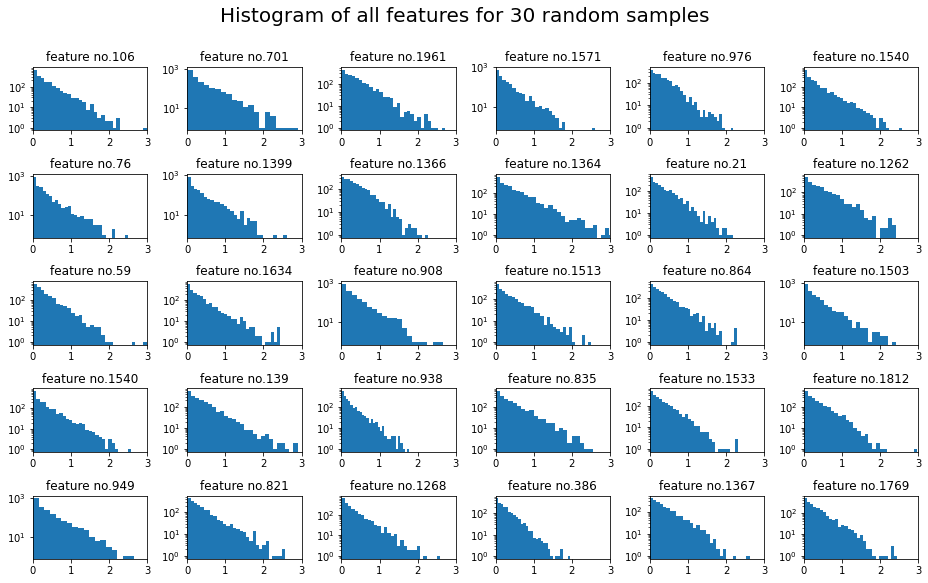

In [7]:
# Plot histogram for 30 ramdom samples
fig, axs = plt.subplots(5,6, figsize=(13,8))
#xmin, xmax = np.min(features), np.max(features)
#ymin, ymax = np.min(features_2d[:, 1]), np.max(features_2d[:, 1])
idxs = np.random.randint(0, features.shape[1], 30)
for i in range(30):
    idx = idxs[i]
    # Plot their components
    axs[i//6,i%6].hist(
        features[idx,:], bins=30, log=True
    )
    axs[i//6,i%6].set_xlim([0, 3])
    axs[i//6,i%6].set_title('feature no.'+str(idx))
    #axs[i//6,i%6].set_ylim([0, 2])
    #axs[i//5,i%5].set_title(list(image40X.class_indices)[i])

fig.suptitle('Histogram of all features for 30 random samples', fontsize=20, verticalalignment='baseline')
fig.tight_layout()

One can see that for each sample there are many features that have values not far away from 0. That means, that many features neary vanish for each sample. Note that y-axis is log scaled.

In the following I compute sum over all samples for each feature, and visualize the sum with a boxplot.

#### Compute sum over all features for each sample

In [8]:
features_sum = features.sum(axis=0)
features_sum

array([3616.21174128, 1567.9690377 , 2129.04415892, ..., 3389.71404772,
       5979.58584847, 3390.879956  ])

#### Boxplot for features log sums

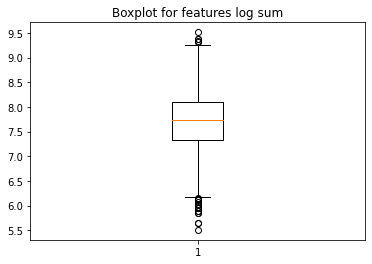

In [9]:
bp = plt.boxplot(np.log(features_sum))
plt.title('Boxplot for features log sum')
plt.show()

There are a few outliers near 6.0 and a few ones near 9.5. These are features with very low summed features values, or with very high summed feature values.

In the following I indentify the outliers and exlude them from the feature space.

#### Get outliers

In [10]:
outliers = [flier.get_ydata() for flier in bp["fliers"]]
outliers

[array([6.06866213, 5.94355514, 6.01794087, 6.11753063, 6.14125963,
        5.89672218, 5.94768031, 5.89420761, 5.8406038 , 6.14775637,
        5.96214815, 5.64390071, 6.12513668, 6.03046188, 5.50616624,
        6.13125675, 5.64467537, 5.84816632, 9.38539444, 9.37243659,
        9.51343438, 9.30786902, 9.33271183])]

#### Get whiskers

In [11]:
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]
whiskers

[array([7.32446369, 6.16506743]), array([8.10695409, 9.24638757])]

#### Get index of feature outliers

In [12]:
out_low = np.where(np.log(features.sum(axis=0))<=whiskers[0][1])
out_low[0]

array([  45,  177,  236,  340,  648, 1248, 1263, 1431, 1525, 1581, 1597,
       1649, 1664, 1684, 1715, 1849, 1853, 2002, 2034])

In [13]:
out_high = np.where(np.log(features.sum(axis=0))>=whiskers[1][1])
out_high

(array([1241, 1355, 1388, 1455, 1516, 1783]),)

#### Remove outliers from feature space

In [14]:
features_redim = np.delete(features, out_low[0], axis=1)
features_redim.shape

(7980, 2029)

In [15]:
features_redim = np.delete(features_redim, out_high[0], axis=1)
features_redim.shape

(7980, 2023)

#### Use redimensioned features space

In [16]:
features = features_redim
print(features.shape)

(7980, 2023)


## 4. PCA to reduce high-level feature space dimensionality

#### Import packages

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### Compute PCA with two components

In [18]:
# Create Standard scaler
scaler = StandardScaler()

# Rescale data
features_rescaled = scaler.fit_transform(features)

# Create PCA transformer
pca2 = PCA(n_components=2)

# Apply PCA to rescaled data
features_2d = pca2.fit_transform(features_rescaled)

# Features dimension
print(features_2d.shape)

(7980, 2)


#### Scatterplot of first two PCA components

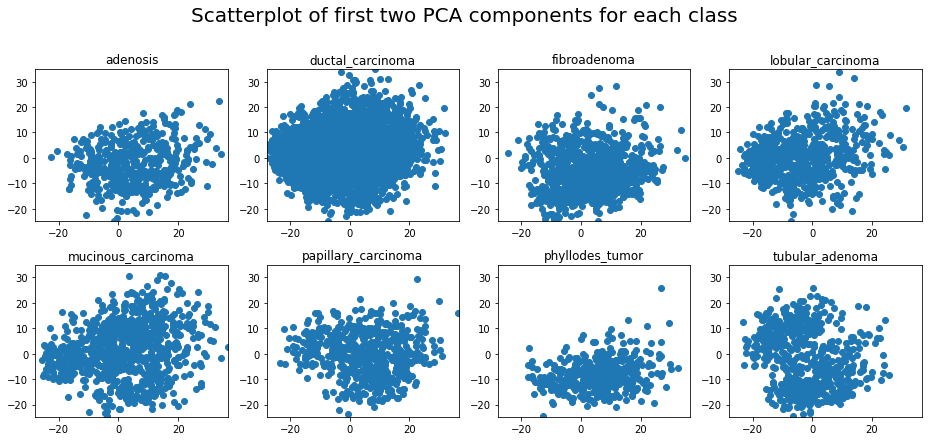

In [19]:
# Plot each class in a separate plot
fig, axs = plt.subplots(2,4, figsize=(13,6))
xmin, xmax = np.min(features_2d[:, 0]), np.max(features_2d[:, 0])
ymin, ymax = np.min(features_2d[:, 1]), np.max(features_2d[:, 1])

for i in range(8):
    idx = (labs == i)

    # Plot their components
    axs[i//4,i%4].scatter(
        features_2d[idx, 0], features_2d[idx, 1]
    )
    axs[i//4,i%4].set_xlim([xmin, xmax])
    axs[i//4,i%4].set_ylim([ymin, ymax])
    axs[i//4,i%4].set_title(class_names[i])

fig.suptitle('Scatterplot of first two PCA components for each class', fontsize=20, verticalalignment='baseline')
fig.tight_layout()

All plots show similar patterns. Adenosis and phyllodes_tumor have nearly any samples in the upper left corner. Tubular_adenoma has something like two regions, where most of the samples lie.

#### Get first 10 components from PCA

In [20]:
# Create PCA transformer
pca = PCA(n_components=10)

# Apply PCA
pca.fit(features, y=None); # Unsupervised learning, no y variable

#### Compute proportion of variance explained 

In [21]:
# Proportion of variance explained
pve = pca.explained_variance_ratio_
pve

array([0.0742619 , 0.05914705, 0.04091448, 0.03602754, 0.02768095,
       0.02394403, 0.02178406, 0.01906473, 0.01699871, 0.01628899])

#### Plot proportion of variance explained

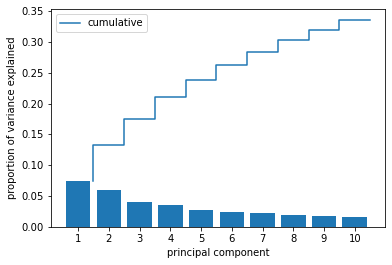

In [22]:
import numpy as np

# Create bar plot
fig = plt.figure()
xcor = np.arange(1, len(pve) + 1) # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, # 1.5,2.5,..,n_components+0.5
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Add labels
plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')
plt.legend()
plt.show()

The first 10 components explain about 35% of the total variance. That means, that by looking at only the first 10 components we will probally not gain much insides. But nevertheless we continiue with exploring this 10-dimensional feature space, as exploring and visualize a bigger space is nearly unfeasible.

## 5. Explore 10-dimensional feature space derived from PCA

#### Extract first 10 component's values

In [23]:
features_10d = pca.fit_transform(features)
features_10d.shape

(7980, 10)

In [24]:
# DataFrame with features
feat_df = pd.DataFrame(features_10d)
feat_df.head()

0         1         2         3         4         5         6  \
0 -2.457285 -2.778853  6.467077 -0.583069  2.244885 -3.920999 -0.073088   
1  0.106895 -0.464831 -1.262377  1.330357 -1.922578  0.307266 -2.365386   
2  4.618954  9.082774 -4.695061 -3.943085  6.591781 -1.943323 -0.634684   
3  1.988566 -4.955955  3.440035  1.680117 -1.393457 -2.232809 -0.192284   
4 -6.094987  0.833747 -1.883486  2.758630 -2.380893 -0.550170  2.697326   

          7         8         9  
0  3.061783  0.273392 -0.965683  
1 -1.060014 -2.574219  0.344205  
2  4.185044 -0.847078  3.392393  
3  3.280273  0.711078  1.077573  
4  0.268243 -0.215188  0.184916

#### Plot distribution of each component for each class

In [25]:
feat_df_labs = feat_df
feat_df_labs['labs'] = labs
feat_df_labs.head()

0         1         2         3         4         5         6  \
0 -2.457285 -2.778853  6.467077 -0.583069  2.244885 -3.920999 -0.073088   
1  0.106895 -0.464831 -1.262377  1.330357 -1.922578  0.307266 -2.365386   
2  4.618954  9.082774 -4.695061 -3.943085  6.591781 -1.943323 -0.634684   
3  1.988566 -4.955955  3.440035  1.680117 -1.393457 -2.232809 -0.192284   
4 -6.094987  0.833747 -1.883486  2.758630 -2.380893 -0.550170  2.697326   

          7         8         9  labs  
0  3.061783  0.273392 -0.965683     1  
1 -1.060014 -2.574219  0.344205     0  
2  4.185044 -0.847078  3.392393     1  
3  3.280273  0.711078  1.077573     1  
4  0.268243 -0.215188  0.184916     2

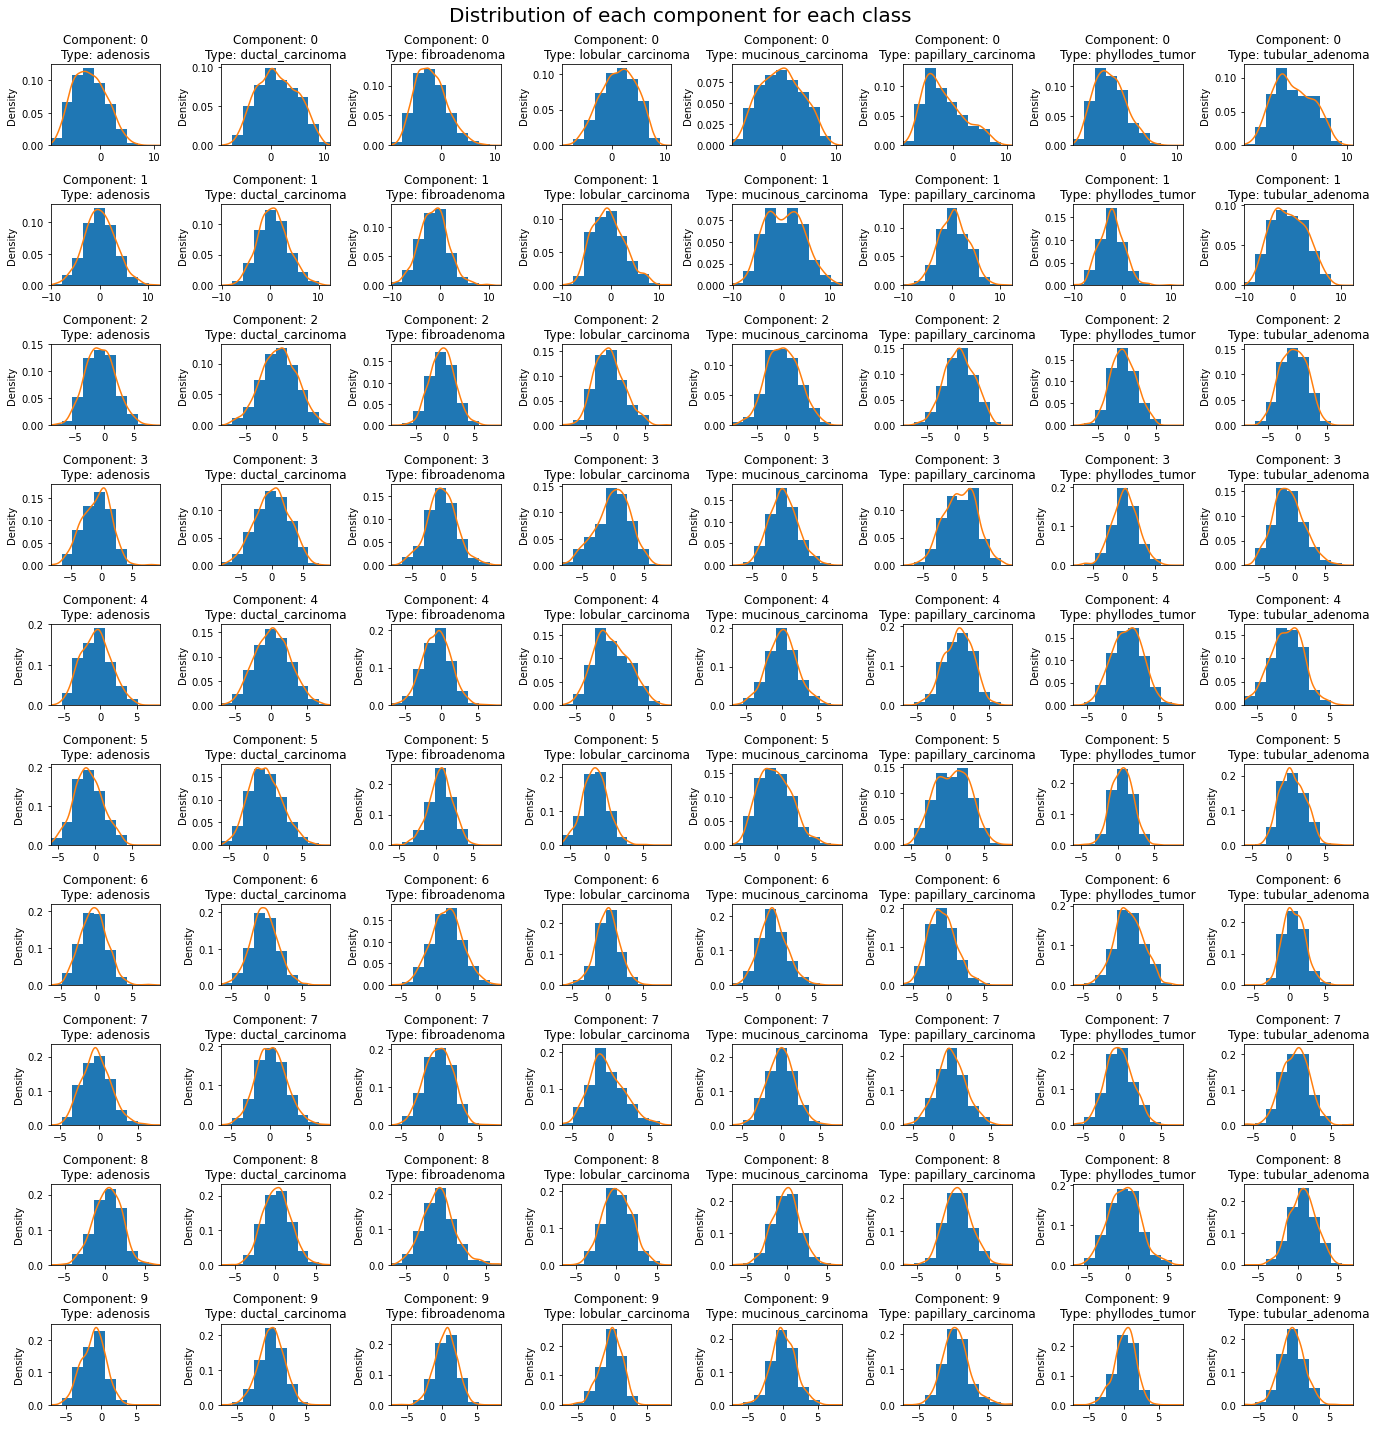

In [26]:
fig, axs = plt.subplots(10,8, figsize=(19,20))
for j in range(10):  # component
    xmin, xmax = np.min(feat_df_labs.loc[:,j]), np.max(feat_df_labs.loc[:,j])
    for i in range(8):  # class
        cl = class_names[i]
        axs[j,i].hist(feat_df_labs.loc[feat_df_labs.labs==i,j], bins=10, density=True, range=(xmin,xmax))
        feat_df_labs.loc[feat_df_labs.labs==i,j].plot(kind='density', ax=axs[j,i])
        axs[j,i].set_xlim([xmin, xmax])
        axs[j,i].set_title('Component: '+str(j)+'\nType: '+cl)
fig.suptitle('Distribution of each component for each class', fontsize=20, verticalalignment='baseline')
fig.tight_layout()

It seems very difficult to visually make out a clear pattern in the histograms. For component 0, e.x., class papilary_carcinoma has different distribution. While all are gaussian-like, class papilary_carcinoma is more left-shifted then the other ones.

#### Explore relations between components

In [27]:
import seaborn as sns

In [28]:
labs_dict = {int(y):x for x,y in np.c_[class_names, np.arange(8)]}
labs_dict

{0: 'adenosis',
 1: 'ductal_carcinoma',
 2: 'fibroadenoma',
 3: 'lobular_carcinoma',
 4: 'mucinous_carcinoma',
 5: 'papillary_carcinoma',
 6: 'phyllodes_tumor',
 7: 'tubular_adenoma'}

In [29]:
feat_df_labs.labs = feat_df_labs.labs.map(labs_dict)
feat_df_labs.head()

0         1         2         3         4         5         6  \
0 -2.457285 -2.778853  6.467077 -0.583069  2.244885 -3.920999 -0.073088   
1  0.106895 -0.464831 -1.262377  1.330357 -1.922578  0.307266 -2.365386   
2  4.618954  9.082774 -4.695061 -3.943085  6.591781 -1.943323 -0.634684   
3  1.988566 -4.955955  3.440035  1.680117 -1.393457 -2.232809 -0.192284   
4 -6.094987  0.833747 -1.883486  2.758630 -2.380893 -0.550170  2.697326   

          7         8         9              labs  
0  3.061783  0.273392 -0.965683  ductal_carcinoma  
1 -1.060014 -2.574219  0.344205          adenosis  
2  4.185044 -0.847078  3.392393  ductal_carcinoma  
3  3.280273  0.711078  1.077573  ductal_carcinoma  
4  0.268243 -0.215188  0.184916      fibroadenoma

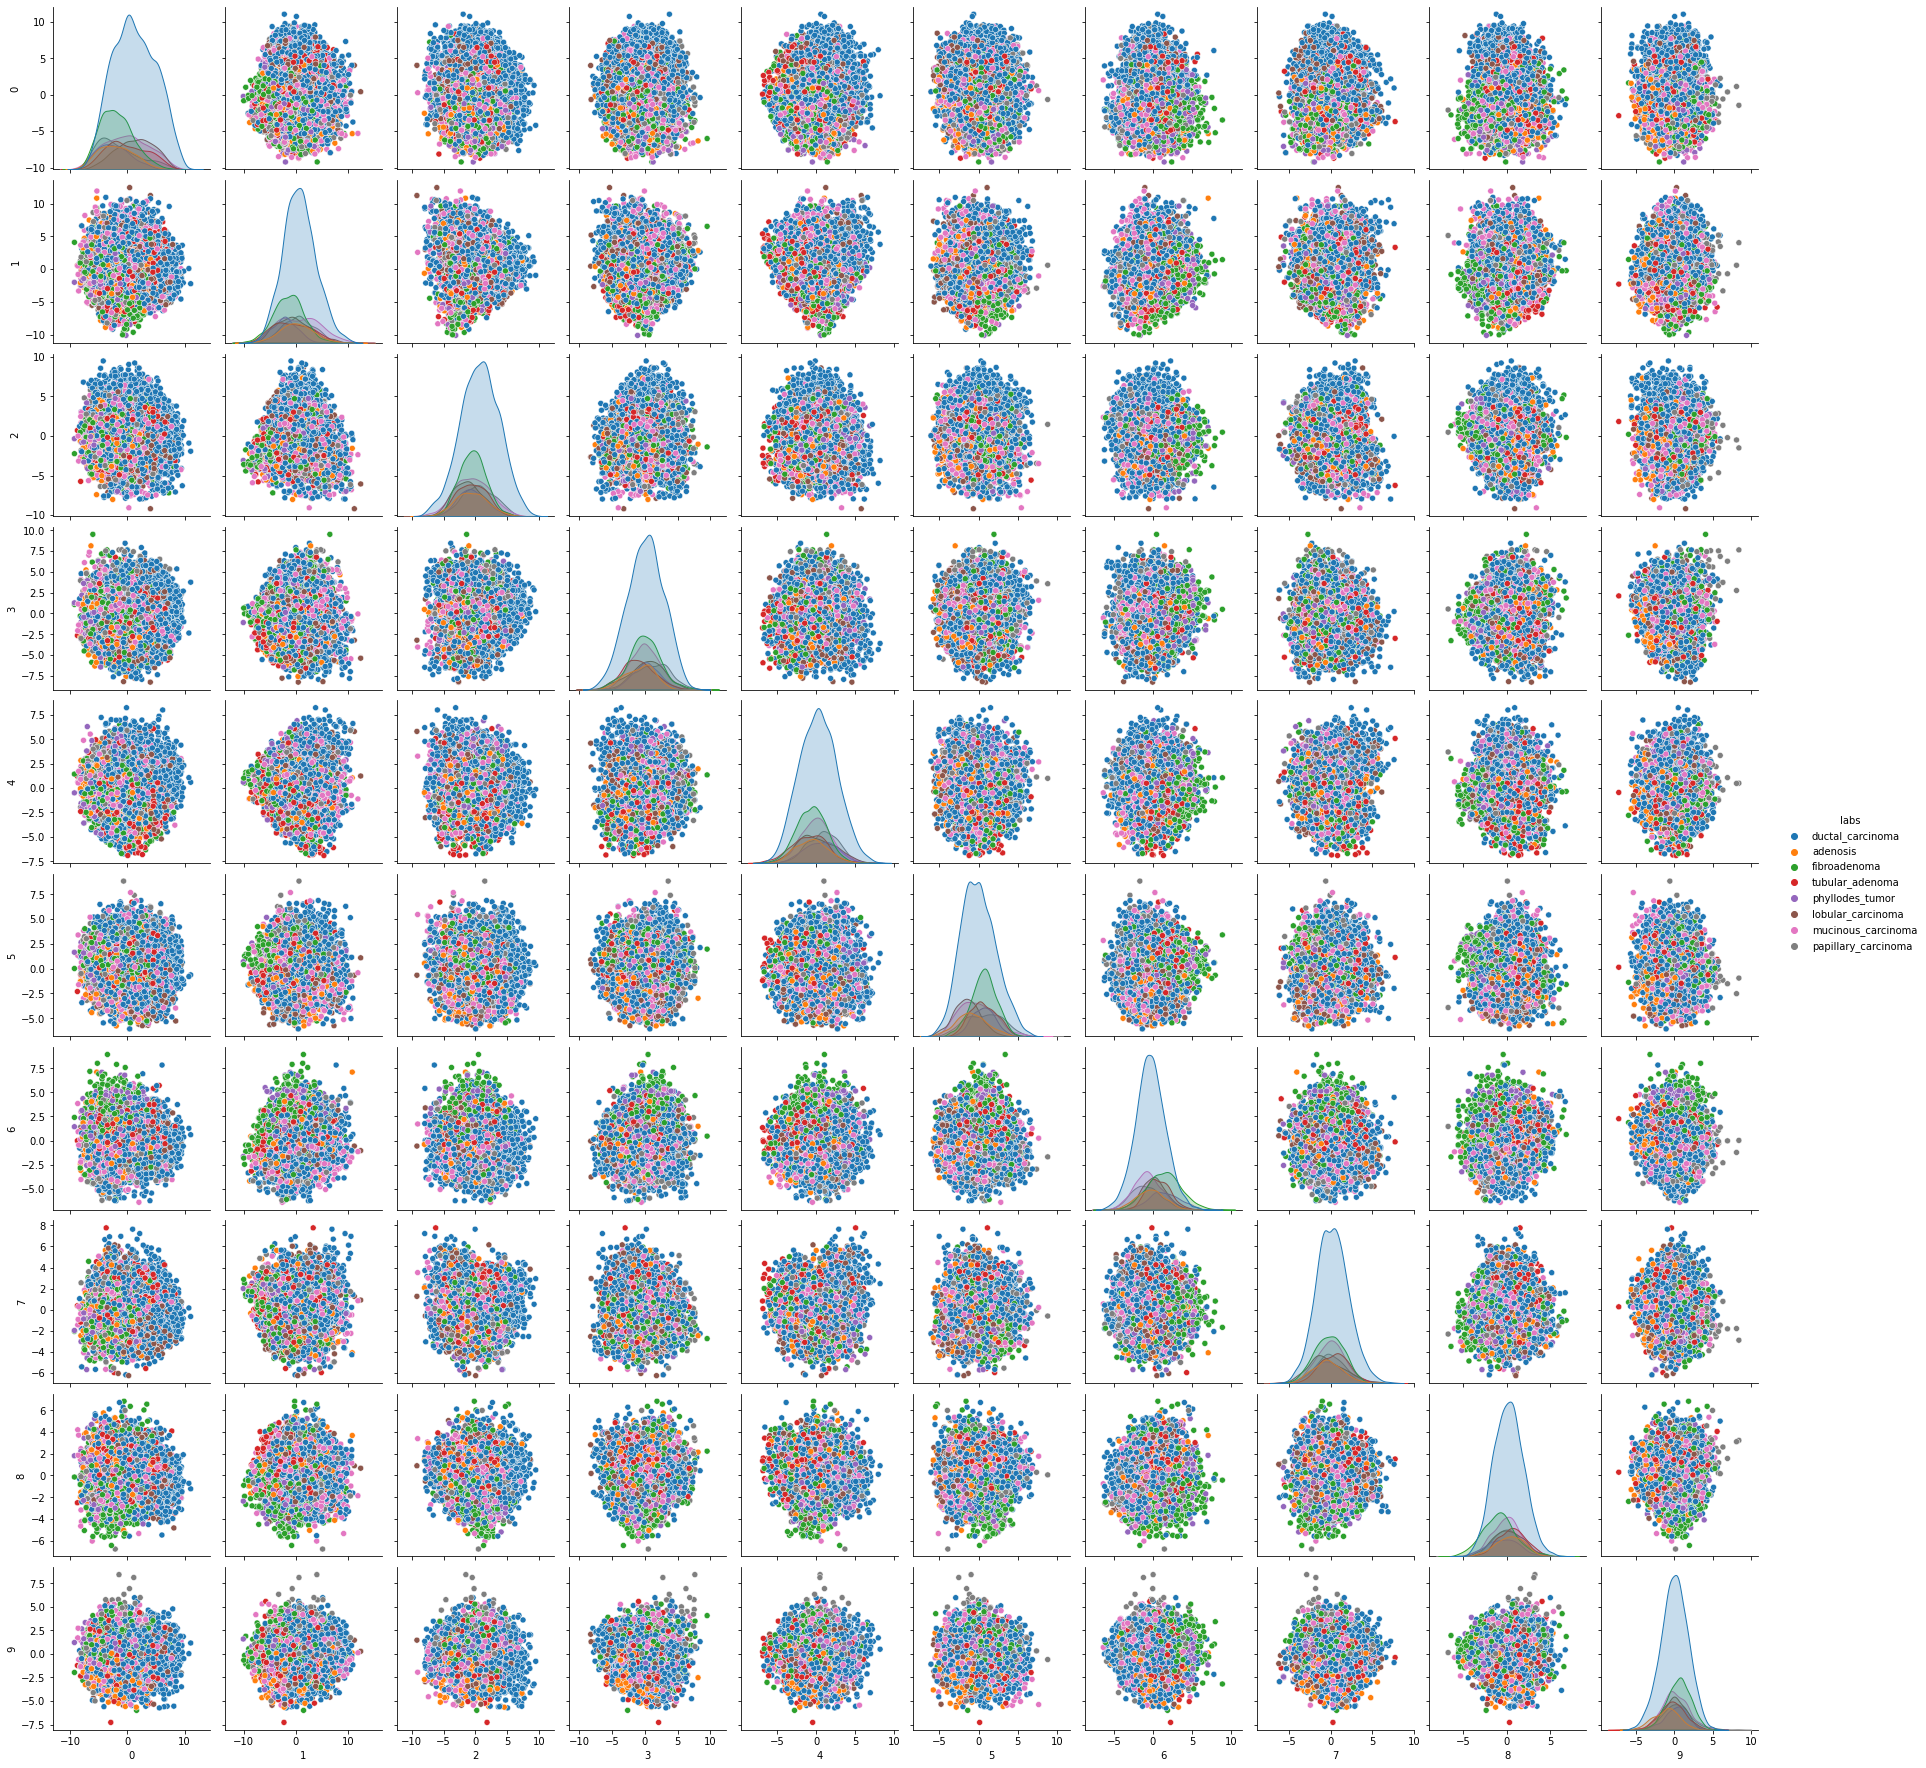

In [30]:
sns.pairplot(feat_df_labs.iloc[:,:], hue='labs');

The pattern is very simillar for each relation. Particularly, there is any class (color) standing out form all other classes.

#### Explore RGB distribution of feature patches for each class

Here, for each class, I look at the RGB distribution of the feature patches. In other words, I count for each color, i.e., for red, green, and blue, how many pixels that are in the range between 0 and 1.

In [31]:
# import packges
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
# define image data generator (with rescale=1/255, such that every pixel-value ist between 0 and 1)
image_generator = ImageDataGenerator(rescale=1/255)

In [33]:
# read images from directory
image40Xpatches = image_generator.flow_from_directory(
    os.path.join('data','breast','40Xpatches'),
    batch_size=64, 
    target_size=(230, 350),
    class_mode = 'sparse',
    shuffle=True
)

Found 7980 images belonging to 8 classes.


In [34]:
# Check shape of images and labels
image40Xpatches.reset()
imgs, labels = image40Xpatches.next()
print(imgs.shape, labels.shape)

(64, 230, 350, 3) (64,)


In [35]:
# Collect at leat 20 images per class
imgs_all = []
for i in range(8):   # i=class
    image40Xpatches.reset()
    j = 0
    while True:
        imgs, labels = image40Xpatches.next()
        if j==0:
            imgs_cat = imgs[labels==i,:,:,:]
        else:
            imgs_cat = np.r_[imgs_cat, imgs[labels==i,:,:,:]]
        labs_cat = list(image40Xpatches.class_indices)[i]
        j+=1
        if np.alen(imgs_cat) >= 20:  # at least 20 images per class
            break
    imgs_all.append(imgs_cat)

In [36]:
for i in range(8):
    print('shape of images of class',i,':',imgs_all[i].shape)

shape of images of class 0 : (20, 230, 350, 3)
shape of images of class 1 : (33, 230, 350, 3)
shape of images of class 2 : (25, 230, 350, 3)
shape of images of class 3 : (29, 230, 350, 3)
shape of images of class 4 : (28, 230, 350, 3)
shape of images of class 5 : (20, 230, 350, 3)
shape of images of class 6 : (24, 230, 350, 3)
shape of images of class 7 : (22, 230, 350, 3)


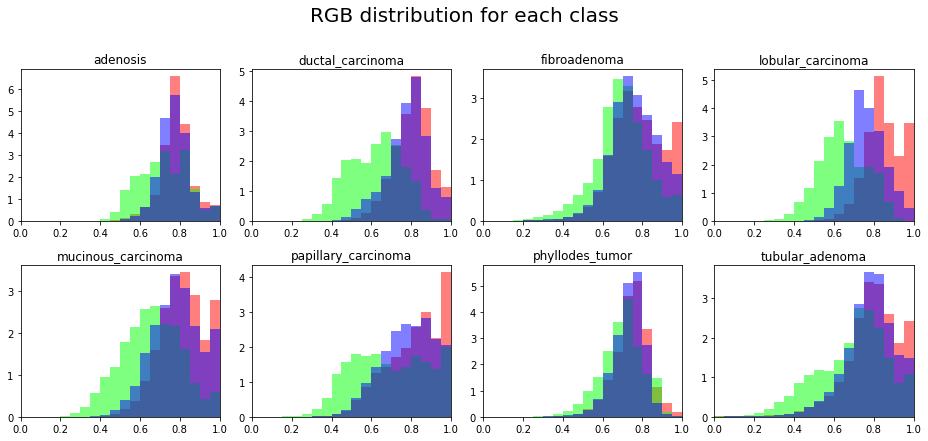

In [37]:
# Plot histograms for each class
fig, axs = plt.subplots(2,4, figsize=(13,6))
for i in range(8):
    img0 = imgs_all[i][:,:,:,0]
    img1 = imgs_all[i][:,:,:,1]
    img2 = imgs_all[i][:,:,:,2]
    n = imgs_all[i].shape[0]
    img0r = img0.reshape(230*350*n)
    img1r = img1.reshape(230*350*n)
    img2r = img2.reshape(230*350*n)
    axs[i//4,i%4].set_title(list(image40Xpatches.class_indices)[i])
    axs[i//4,i%4].hist(img0r, fc=(1, 0, 0, 0.5), bins=20, density=True, range=(0,1))
    axs[i//4,i%4].hist(img1r, fc=(0, 1, 0, 0.5), bins=20, density=True, range=(0,1))
    axs[i//4,i%4].hist(img2r, fc=(0, 0, 1, 0.5), bins=20, density=True, range=(0,1))
    axs[i//4,i%4].set_xlim([0, 1])
fig.suptitle('RGB distribution for each class', fontsize=20, verticalalignment='baseline')
fig.tight_layout()

Adenosis and phyllodes_tumor have a similar RGB distribution, all RGB channels are tidly spread around 0.75 One can also observe that all other classes than adenosis and phyllodes_tumor have high red channel values, while classes adenosis and phyllodes_tumor don't max out the red channel. All other classes are very difficult to distinguish visually.

## 6. Check for outlier candidates

In [38]:
# function to compute z-scores
def zscore(x):
    return (x-np.mean(x)) / np.std(x)

In [39]:
# DataFrame with z-scores for each component, zscores are computed per class
zscores = feat_df_labs.groupby('labs').take(np.arange(10), axis=1).apply(lambda x: zscore(x))
zscores.head()

0         1         2         3         4         5         6  \
0 -0.654005 -0.828720  2.318880 -0.222798  0.978616 -1.837836 -0.035916   
1  0.028450 -0.138624 -0.452647  0.508346 -0.838112  0.144020 -1.162361   
2  1.229332  2.708699 -1.683494 -1.506703  2.873565 -0.910867 -0.311887   
3  0.529256 -1.477984  1.233483  0.641994 -0.607452 -1.046554 -0.094489   
4 -1.622178  0.248643 -0.675356  1.054108 -1.037906 -0.257873  1.325478   

          7         8         9  
0  1.608298  0.152085 -0.548785  
1 -0.556806 -1.432012  0.195607  
2  2.198327 -0.471221  1.927851  
3  1.723067  0.395566  0.612370  
4  0.140903 -0.119707  0.105085

In [40]:
# set True if abs(z-scores)<2
out_cand = zscores.apply(abs) < 2
out_cand.head()

0      1      2     3      4     5     6      7     8     9
0  True   True  False  True   True  True  True   True  True  True
1  True   True   True  True   True  True  True   True  True  True
2  True  False   True  True  False  True  True  False  True  True
3  True   True   True  True   True  True  True   True  True  True
4  True   True   True  True   True  True  True   True  True  True

In [41]:
# Mark as outlier candidate, if 5 or more than 5 entries per sample are marked as outlier
out_cand['sum'] = out_cand.iloc[:,:10].sum(axis=1)
out_cand['candidate'] = out_cand['sum'] < 8
out_cand.sort_values(by='sum').head()

0      1      2      3      4      5     6      7     8     9  sum  \
6166  True  False  False   True  False  False  True  False  True  True    5   
3846  True  False  False  False  False   True  True  False  True  True    5   
1670  True  False  False  False   True  False  True  False  True  True    5   
2899  True  False  False  False   True  False  True  False  True  True    5   
7195  True  False  False  False  False   True  True  False  True  True    5   

      candidate  
6166       True  
3846       True  
1670       True  
2899       True  
7195       True

In [42]:
# total number of outlier candidates
out_cand.candidate.sum()

65

In [43]:
# get ids of the outlier candidates
id_out = out_cand[out_cand.candidate == True].index
id_out

Int64Index([   2,   20,  330,  342,  414,  541,  614,  659,  853, 1019, 1022,
            1244, 1445, 1629, 1636, 1670, 2746, 2819, 2899, 3082, 3410, 3471,
            3613, 3846, 3912, 4165, 4203, 4383, 4534, 4613, 4995, 5069, 5236,
            5315, 5335, 5363, 5459, 5469, 5641, 5987, 6071, 6166, 6200, 6460,
            6486, 6681, 6740, 6762, 6783, 6789, 6881, 7018, 7195, 7272, 7389,
            7443, 7506, 7508, 7663, 7743, 7799, 7826, 7895, 7912, 7956],
           dtype='int64')

In [44]:
# get filenames of the outlier candidates
fn_out = fn[id_out]
fn_out[:5]

array(['ductal_carcinoma/SOB_M_DC-14-11951-40-005__patch_0_1.png',
       'ductal_carcinoma/SOB_M_DC-14-2773-40-026__patch_1_1.png',
       'ductal_carcinoma/SOB_M_DC-14-16448-40-005__patch_1_1.png',
       'ductal_carcinoma/SOB_M_DC-14-15792-40-012__patch_1_0.png',
       'ductal_carcinoma/SOB_M_DC-14-20629-40-036__patch_1_0.png'],
      dtype='<U60')

#### Plot some outlier candidates' image

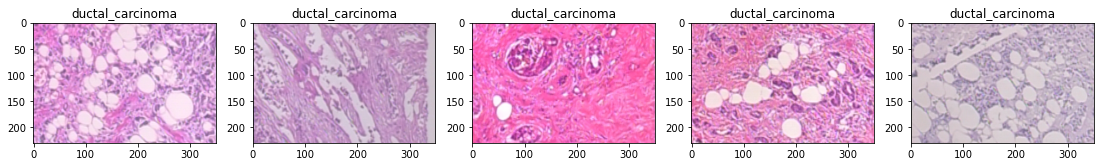

In [45]:
fig, axs = plt.subplots(1,5, figsize=(19,5))
for i in range(5):
    img = plt.imread(os.path.join('data','breast','40Xpatches', fn_out[i]))
    axs[i].imshow(img)
    axs[i].set_title(re.sub('(.*)/(.*)', '\\1', fn_out[i]))

#### Class to which outlier candidates belong

In [46]:
out_df = feat_df_labs.iloc[id_out,-1].value_counts(normalize=True).sort_index()
out_df = out_df*100
out_df2 = feat_df_labs.iloc[id_out,-1].value_counts(normalize=False).sort_index()

In [47]:
out_df = pd.DataFrame(out_df)
out_df.columns=['proportion outliers (%)']
out_df = out_df.round(1)
out_df

proportion outliers (%)
adenosis                                 1.5
ductal_carcinoma                        63.1
fibroadenoma                             9.2
lobular_carcinoma                        7.7
mucinous_carcinoma                       4.6
papillary_carcinoma                     10.8
tubular_adenoma                          3.1

In [48]:
out_df2 = pd.DataFrame(out_df2)
out_df2.columns=['count outliers']
out_df2 = out_df2.round(1)
out_df2

count outliers
adenosis                          1
ductal_carcinoma                 41
fibroadenoma                      6
lobular_carcinoma                 5
mucinous_carcinoma                3
papillary_carcinoma               7
tubular_adenoma                   2

In [49]:
class_df = class_df.merge(out_df, left_index=True, right_index=True, how='left')

In [50]:
class_df = class_df.merge(out_df2, left_index=True, right_index=True, how='left')
class_df

count  proportion (%)  proportion outliers (%)  \
adenosis               456             5.7                      1.5   
ductal_carcinoma      3456            43.3                     63.1   
fibroadenoma          1012            12.7                      9.2   
lobular_carcinoma      624             7.8                      7.7   
mucinous_carcinoma     820            10.3                      4.6   
papillary_carcinoma    580             7.3                     10.8   
phyllodes_tumor        436             5.5                      NaN   
tubular_adenoma        596             7.5                      3.1   

                     count outliers  
adenosis                        1.0  
ductal_carcinoma               41.0  
fibroadenoma                    6.0  
lobular_carcinoma               5.0  
mucinous_carcinoma              3.0  
papillary_carcinoma             7.0  
phyllodes_tumor                 NaN  
tubular_adenoma                 2.0

## 7. Check outliers candidates for EfficientNetB0

#### Load high-level features from file

In [51]:
with np.load(os.path.join('data', 'HLfeatures', 'features_patches_EfficientNetB0.npz')) as features_npz:
    features_EfficientNetB0 = dict(features_npz)
features = features_EfficientNetB0['arr_0'][:,:1280]
labs = features_EfficientNetB0['arr_0'][:,1280]
fn2 = features_EfficientNetB0['arr_0'][:,1281]
print('Shape of features:', features.shape, '\nShape of labs:', labs.shape, '\nShape of filenames:', fn2.shape)

Shape of features: (7980, 1280) 
Shape of labs: (7980,) 
Shape of filenames: (7980,)


#### Set data type for features and labels

In [52]:
features = features.astype(float)
labs = np.char.ljust(labs, 1).astype(int)

#### Descriptive statistics on features

As highl-level feature space is very large (d=2048), we reduce dimensonality by conducting a Principal Component Analysis (PCA). We do then analyse the first most important components from the PCA.

In [53]:
print(features.shape, labs.shape)

(7980, 1280) (7980,)


In [54]:
# Create PCA transformer
pca = PCA(n_components=10)

# Apply PCA
pca.fit(features, y=None); # Unsupervised learning, no y variable

In [55]:
features_10d = pca.fit_transform(features)
features_10d.shape

(7980, 10)

In [56]:
# DataFrame with features
feat_df = pd.DataFrame(features_10d)
feat_df.head()

0         1         2         3         4         5         6  \
0  0.938330 -2.767859  1.922870  2.907467 -0.546229 -0.904351 -1.338795   
1 -1.713555 -0.998701  4.615586  1.338614 -0.730514 -1.052227 -0.337748   
2  1.189156 -0.177107 -1.370136 -1.366303 -2.105764 -1.727645 -3.068495   
3  1.736152 -1.244801  0.028753 -1.728189  1.347294 -3.001735 -0.237272   
4  4.303658 -0.016104  1.048724  0.459926  0.636838 -0.921344 -0.915502   

          7         8         9  
0 -0.095702  1.024449  0.215333  
1  1.540191 -0.805443 -0.642528  
2  0.792780  1.221031  1.690967  
3  0.375904  0.179026  0.651650  
4 -0.419527 -0.324086  0.256441

#### Distribution of each component for each class

In [57]:
feat_df_labs = feat_df
feat_df_labs['labs'] = labs
feat_df_labs.head()

0         1         2         3         4         5         6  \
0  0.938330 -2.767859  1.922870  2.907467 -0.546229 -0.904351 -1.338795   
1 -1.713555 -0.998701  4.615586  1.338614 -0.730514 -1.052227 -0.337748   
2  1.189156 -0.177107 -1.370136 -1.366303 -2.105764 -1.727645 -3.068495   
3  1.736152 -1.244801  0.028753 -1.728189  1.347294 -3.001735 -0.237272   
4  4.303658 -0.016104  1.048724  0.459926  0.636838 -0.921344 -0.915502   

          7         8         9  labs  
0 -0.095702  1.024449  0.215333     1  
1  1.540191 -0.805443 -0.642528     0  
2  0.792780  1.221031  1.690967     1  
3  0.375904  0.179026  0.651650     1  
4 -0.419527 -0.324086  0.256441     4

In [58]:
feat_df_labs.labs = feat_df_labs.labs.map(labs_dict)
feat_df_labs.head()

0         1         2         3         4         5         6  \
0  0.938330 -2.767859  1.922870  2.907467 -0.546229 -0.904351 -1.338795   
1 -1.713555 -0.998701  4.615586  1.338614 -0.730514 -1.052227 -0.337748   
2  1.189156 -0.177107 -1.370136 -1.366303 -2.105764 -1.727645 -3.068495   
3  1.736152 -1.244801  0.028753 -1.728189  1.347294 -3.001735 -0.237272   
4  4.303658 -0.016104  1.048724  0.459926  0.636838 -0.921344 -0.915502   

          7         8         9                labs  
0 -0.095702  1.024449  0.215333    ductal_carcinoma  
1  1.540191 -0.805443 -0.642528            adenosis  
2  0.792780  1.221031  1.690967    ductal_carcinoma  
3  0.375904  0.179026  0.651650    ductal_carcinoma  
4 -0.419527 -0.324086  0.256441  mucinous_carcinoma

In [59]:
# DataFrame with z-scores for each component, zscores are computed per class
zscores = feat_df_labs.groupby('labs').take(np.arange(10), axis=1).apply(lambda x: zscore(x))
zscores.head()

0         1         2         3         4         5         6  \
0  0.391282 -1.238448  1.053105  1.673698 -0.378700 -0.719629 -1.090544   
1 -0.714550 -0.446858  2.527834  0.770580 -0.506464 -0.837301 -0.275120   
2  0.495876 -0.079245 -0.750387 -0.786519 -1.459924 -1.374758 -2.499506   
3  0.723973 -0.556972  0.015747 -0.994841  0.934078 -2.388604 -0.193274   
4  1.794619 -0.007205  0.574358  0.264758  0.441519 -0.733152 -0.745742   

          7         8         9  
0 -0.087287  1.026688  0.222070  
1  1.404771 -0.807204 -0.662631  
2  0.723075  1.223700  1.743873  
3  0.342853  0.179417  0.672038  
4 -0.382641 -0.324794  0.264464

In [60]:
# set True if abs(z-scores)<2
out_cand = zscores.apply(abs) < 2
out_cand.head()

0     1      2     3     4      5      6     7     8     9
0  True  True   True  True  True   True   True  True  True  True
1  True  True  False  True  True   True   True  True  True  True
2  True  True   True  True  True   True  False  True  True  True
3  True  True   True  True  True  False   True  True  True  True
4  True  True   True  True  True   True   True  True  True  True

In [61]:
# Mark as outlier candidate, if 4 or more than 4 entries per sample are marked as outlier
out_cand['sum'] = out_cand.iloc[:,:10].sum(axis=1)
out_cand['candidate'] = out_cand['sum'] < 8
out_cand.sort_values(by='sum').head()

0      1     2      3      4      5      6      7      8      9  \
6174  False  False  True   True   True  False   True  False   True   True   
5290  False   True  True   True   True  False   True  False   True  False   
7509   True  False  True   True  False   True  False   True  False   True   
7207   True   True  True  False   True   True  False  False   True   True   
7790   True   True  True   True   True  False  False   True  False   True   

      sum  candidate  
6174    6       True  
5290    6       True  
7509    6       True  
7207    7       True  
7790    7       True

In [62]:
# total number of outlier candidates
out_cand.candidate.sum()

66

In [63]:
# get ids of the outlier candidates
id_out2 = out_cand[out_cand.candidate == True].index
id_out2

Int64Index([ 462,  464,  584,  714,  769,  891,  912,  979, 1056, 1287, 2108,
            2113, 2649, 2710, 2843, 3227, 3248, 3383, 3421, 3715, 3949, 4084,
            4133, 4203, 4346, 4366, 4392, 4971, 4996, 5071, 5290, 5312, 5342,
            5394, 5420, 5523, 5726, 5911, 5940, 6087, 6114, 6174, 6219, 6312,
            6362, 6557, 6616, 6626, 6634, 6686, 6747, 6903, 6933, 7021, 7049,
            7098, 7171, 7192, 7207, 7403, 7407, 7509, 7528, 7616, 7649, 7790],
           dtype='int64')

In [64]:
# get filenames of the outlier candidates
fn_out2 = fn2[id_out2]
fn_out2[:5]

array(['papillary_carcinoma/SOB_M_PC-14-9146-40-002__patch_0_1.png',
       'ductal_carcinoma/SOB_M_DC-14-3909-40-020__patch_1_0.png',
       'ductal_carcinoma/SOB_M_DC-14-13993-40-010__patch_1_1.png',
       'ductal_carcinoma/SOB_M_DC-14-2980-40-019__patch_0_1.png',
       'mucinous_carcinoma/SOB_M_MC-14-19979C-40-001__patch_1_0.png'],
      dtype='<U60')

#### Plot some outlier candidates' image

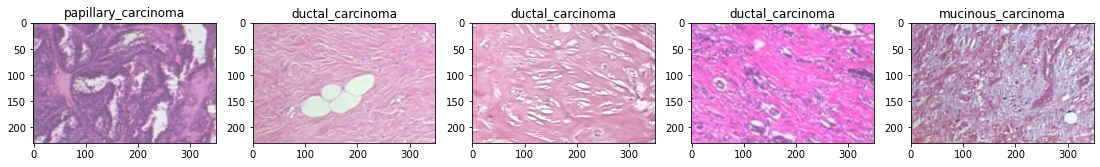

In [65]:
fig, axs = plt.subplots(1,5, figsize=(19,5))
for i in range(5):
    img = plt.imread(os.path.join('data','breast','40Xpatches', fn_out2[i]))
    axs[i].imshow(img)
    axs[i].set_title(re.sub('(.*)/(.*)', '\\1', fn_out2[i]))

#### Class to which outlier candidates belong

In [66]:
out_df = feat_df_labs.iloc[id_out2,-1].value_counts(normalize=True).sort_index()
out_df = out_df*100
out_df2 = feat_df_labs.iloc[id_out2,-1].value_counts(normalize=False).sort_index()

In [67]:
out_df = pd.DataFrame(out_df)
out_df.columns=['proportion outliers (%) EN']
out_df = out_df.round(1)
out_df

proportion outliers (%) EN
adenosis                                    6.1
ductal_carcinoma                           45.5
fibroadenoma                                4.5
lobular_carcinoma                           1.5
mucinous_carcinoma                         18.2
papillary_carcinoma                         9.1
phyllodes_tumor                            12.1
tubular_adenoma                             3.0

In [68]:
out_df2 = pd.DataFrame(out_df2)
out_df2.columns=['count outliers EN']
out_df2 = out_df2.round(1)
out_df2

count outliers EN
adenosis                             4
ductal_carcinoma                    30
fibroadenoma                         3
lobular_carcinoma                    1
mucinous_carcinoma                  12
papillary_carcinoma                  6
phyllodes_tumor                      8
tubular_adenoma                      2

In [69]:
class_df = class_df.merge(out_df, left_index=True, right_index=True, how='left')

In [70]:
class_df = class_df.merge(out_df2, left_index=True, right_index=True, how='left')

In [71]:
a = class_df.sum().round(0)
aa = pd.DataFrame(a.values).T
aa.columns=class_df.columns
aa.index=['Total']
aa

count  proportion (%)  proportion outliers (%)  count outliers  \
Total  7980.0           100.0                    100.0            65.0   

       proportion outliers (%) EN  count outliers EN  
Total                       100.0               66.0

In [72]:
pd.concat([class_df, aa])

count  proportion (%)  proportion outliers (%)  \
adenosis              456.0             5.7                      1.5   
ductal_carcinoma     3456.0            43.3                     63.1   
fibroadenoma         1012.0            12.7                      9.2   
lobular_carcinoma     624.0             7.8                      7.7   
mucinous_carcinoma    820.0            10.3                      4.6   
papillary_carcinoma   580.0             7.3                     10.8   
phyllodes_tumor       436.0             5.5                      NaN   
tubular_adenoma       596.0             7.5                      3.1   
Total                7980.0           100.0                    100.0   

                     count outliers  proportion outliers (%) EN  \
adenosis                        1.0                         6.1   
ductal_carcinoma               41.0                        45.5   
fibroadenoma                    6.0                         4.5   
lobular_carcinoma               5.0                         1.5   
mucinous_carcinoma              3.0                        18.2   
papillary_carcinoma             7.0                         9.1   
phyllodes_tumor                 NaN                        12.1   
tubular_adenoma                 2.0                         3.0   
Total                          65.0                       100.0   

                     count outliers EN  
adenosis                           4.0  
ductal_carcinoma                  30.0  
fibroadenoma                       3.0  
lobular_carcinoma                  1.0  
mucinous_carcinoma                12.0  
papillary_carcinoma                6.0  
phyllodes_tumor                    8.0  
tubular_adenoma                    2.0  
Total                             66.0

If we look at the count of outliers for both models (InceptionV3, and EfficientNetB0), we can see that they differ slitly for most of the classes. Let's check, if the ones for class tubular_adenoma are the same.

## 8. Compare outliers from the two models InceptionV3, and EfficientNetB0

#### Outliers for class *tabular_adenoma*

In [73]:
fns_ta = []
for i in id_out:
    a=re.findall('tubular_adenoma', fn[i])
    if a!=[]:
        fns_ta.append(fn[i])
        print(fn[i])

tubular_adenoma/SOB_B_TA-14-16184-40-013__patch_0_0.png
tubular_adenoma/SOB_B_TA-14-15275-40-011__patch_1_1.png


In [74]:
fns_ta2 = []
for i in id_out2:
    a=re.findall('tubular_adenoma', fn2[i])
    if a!=[]: 
        fns_ta2.append(fn2[i])
        print(fn2[i])

tubular_adenoma/SOB_B_TA-14-16184-40-022__patch_0_1.png
tubular_adenoma/SOB_B_TA-14-16184CD-40-027__patch_1_0.png


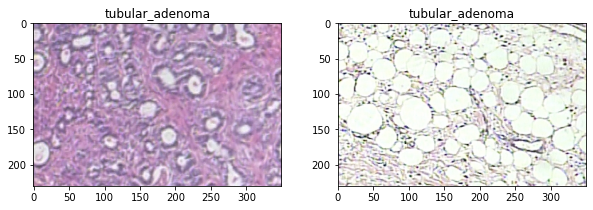

In [75]:
n1 = len(fns_ta)
fig, axs = plt.subplots(1,n1, figsize=(10,3))
for i,fn_ta in enumerate(fns_ta):
    img = plt.imread(os.path.join('data','breast','40Xpatches', fn_ta))
    axs[i].imshow(img)
    axs[i].set_title(re.sub('(.*)/(.*)', '\\1', fn_ta))

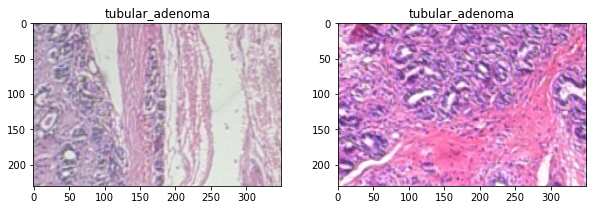

In [76]:
n2 = len(fns_ta2)
fig, axs = plt.subplots(1,n2, figsize=(10,3))
for i,fn_ta2 in enumerate(fns_ta2):
    img = plt.imread(os.path.join('data','breast','40Xpatches', fn_ta2))
    axs[i].imshow(img)
    axs[i].set_title(re.sub('(.*)/(.*)', '\\1', fn_ta2))

Obviously, both models do not classify the same image patches as outliers.

#### Outliers for class *papillary_carcinoma*

In [77]:
fns_pa = []
for i in id_out:
    a=re.findall('papillary_carcinoma', fn[i])
    if a!=[]:
        fns_pa.append(fn[i])
        print(fn[i])

papillary_carcinoma/SOB_M_PC-15-190EF-40-015__patch_1_0.png
papillary_carcinoma/SOB_M_PC-14-19440-40-002__patch_1_1.png
papillary_carcinoma/SOB_M_PC-14-19440-40-019__patch_1_1.png
papillary_carcinoma/SOB_M_PC-15-190EF-40-008__patch_1_0.png
papillary_carcinoma/SOB_M_PC-14-15704-40-008__patch_0_0.png
papillary_carcinoma/SOB_M_PC-14-19440-40-020__patch_1_1.png
papillary_carcinoma/SOB_M_PC-15-190EF-40-018__patch_1_1.png


In [78]:
fns_pa2 = []
for i in id_out2:
    a=re.findall('papillary_carcinoma', fn2[i])
    if a!=[]: 
        fns_pa2.append(fn2[i])
        print(fn2[i])

papillary_carcinoma/SOB_M_PC-14-9146-40-002__patch_0_1.png
papillary_carcinoma/SOB_M_PC-14-19440-40-020__patch_0_0.png
papillary_carcinoma/SOB_M_PC-14-15704-40-016__patch_0_0.png
papillary_carcinoma/SOB_M_PC-14-19440-40-002__patch_1_0.png
papillary_carcinoma/SOB_M_PC-14-19440-40-022__patch_0_0.png
papillary_carcinoma/SOB_M_PC-14-9146-40-003__patch_0_1.png


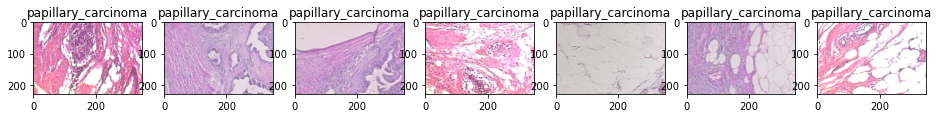

In [79]:
n1=len(fns_pa)
fig, axs = plt.subplots(1,n1, figsize=(16,4))
for i,fn_pa in enumerate(fns_pa):
    img = plt.imread(os.path.join('data','breast','40Xpatches', fn_pa))
    axs[i].imshow(img)
    axs[i].set_title(re.sub('(.*)/(.*)', '\\1', fn_pa))

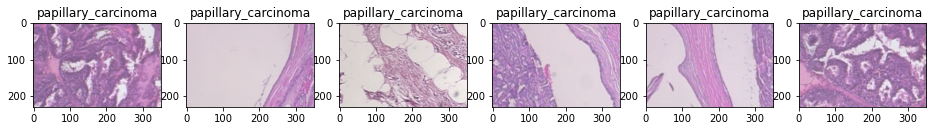

In [80]:
n2=len(fns_pa2)
fig, axs = plt.subplots(1,n2, figsize=(16,4))
for i,fn_pa2 in enumerate(fns_pa2):
    img = plt.imread(os.path.join('data','breast','40Xpatches', fn_pa2))
    axs[i].imshow(img)
    axs[i].set_title(re.sub('(.*)/(.*)', '\\1', fn_pa2))

Obviously, also for this class, both models do not classify the same image patches as outliers.